In [70]:
# Authors: Daelon Kingore, Ashton Barnwell, Jacob Albrecht
# Stock Market prediction using Data Mining/AI algorithms


"""
Notes:Most of the models all worse than a coin flip so if we can find a way to improve them or use better models that would be awesome.
Some may just be good for very short range predictions.

Actually, what may be happening is the models cannot get above the trainging data max, so they just flat line.

TODO: 
Find optimal parameters (k-values),
better evaluation strategies, 
predict future stock prices and other cool predictions to show, 
create graphs of stocks and future prediciton, and probably more. 
More models would certainly be useful, like seeing what happens when you put everything into a Perceptron.
"""


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import KNeighborsRegressor
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Perceptron

# gather data from csv
ticker = "EXPE"
data = pd.read_csv(f'{ticker}.csv')

# drop unnecessary data (can maybe use it in some models but we'll see)
data = data.drop(["Adj Close"], axis=1)
data = data.drop(["Date"], axis=1)
data = data.drop(["Volume"], axis=1)

# standardize data to allow more efficient and accurate processing
standardizer = StandardScaler()
dataStandardized = standardizer.fit_transform(data)

# find y by seeing if next day is up or down
# yClass = np.where(data["Close"].shift(-1) > data["Close"], "Up", "Down")
yRegress = data["Close"]

# using the train test split function. Using both regression and classification for right now
xTrain, xTest, yTrainRegress, yTestRegress = train_test_split(dataStandardized, yRegress, test_size=0.25, shuffle=False)
yTrainClass = np.where(yTrainRegress.shift(-1) > yTrainRegress, "Up", "Down")
yTestClass = np.where(yTestRegress.shift(-1) > yTestRegress, "Up", "Down")

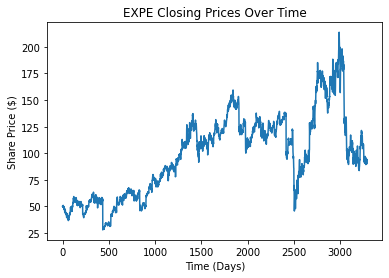

In [71]:
# view our starting data
plt.plot(data['Close'])
plt.title(f"{ticker} Closing Prices Over Time")
plt.xlabel("Time (Days)")
plt.ylabel("Share Price ($)")
plt.show()

In [72]:
# random forest parameter tuning - commented because it takes several minutes - I've found these to be almost useless, I use them as a base and then tune the most important params myself
# randomForestGrid = {
# 'n_estimators': [10, 20, 50, 100, 200, 250, 300, 400, 500],  
# 'max_depth': np.arange(1, 100, 1),  
# 'min_samples_split': [2, 5, 10], 
# 'min_samples_leaf': [1, 2, 4, 6, 8, 10],  
# 'bootstrap': [True, False], 
# 'random_state': [1, 2, 3, 4, 5, 10, 15, 20, 25, 30, 42]
# }
# rscv = RandomizedSearchCV(estimator=RandomForestRegressor(), param_distributions=randomForestGrid, cv=3, n_jobs=-1, verbose=2, n_iter=200) # randomCV using because the GridSearch takes way too long
# rscvFit = rscv.fit(xTrain, yTrainRegress)
# bestParams = rscvFit.best_params_
# print(bestParams)

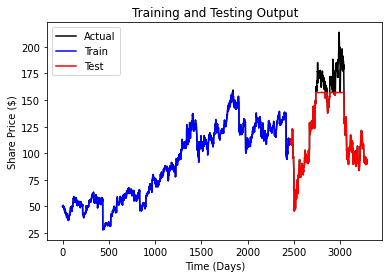

In [73]:
# Random Forest Model using regression (finding actual predicted values)
randomForests = RandomForestRegressor(random_state=30, n_estimators=250, min_samples_split=5, min_samples_leaf=1, max_depth=9, bootstrap=False)
randomForests.fit(xTrain, yTrainRegress)
trainRandomForestsPredict = randomForests.predict(xTrain)
yRandomForestsPredict = randomForests.predict(xTest)

testPredictPlot = np.empty_like(data['Close'])
testPredictPlot[:] = np.nan
testPredictPlot[len(trainRandomForestsPredict):len(data)] = yRandomForestsPredict

# Plot the test predictions
plt.plot(data['Close'], color="black", label=f"Actual")
plt.plot(trainRandomForestsPredict, color="blue", label=f"Train")
plt.plot(testPredictPlot, color="red", label=f"Test")
plt.title("Training and Testing Output")
plt.xlabel("Time (Days)")
plt.ylabel("Share Price ($)")
plt.legend()
plt.show()

In [ ]:
def getColors(real, pred):
    if real == pred:
        return "green"
    else:
        return "red"

In [ ]:
def getSymbols(pred):
    if pred == 'Up':
        return 6
    else:
        return 7

In [74]:
# Random Forest Model using classification (whether it goes up or down)
randomForests = RandomForestClassifier(n_estimators=250, max_depth=9, bootstrap=False)
randomForests.fit(xTrain, yTrainClass)
yRandomForestsPredict = randomForests.predict(xTest)
print(accuracy_score(yTestClass, yRandomForestsPredict))

plt.figure(figsize=(30,12), dpi=600)
data2 = data['Close'].iloc[-len(yTestClass):]
plt.plot(data2.reset_index(drop=True), color='black')
for idx, i in enumerate(data['Close'].iloc[-len(yTestClass):]):
    plt.scatter(idx, i, marker=getSymbols(yRandomForestsPredict[idx]), color=getColors(yTestClass[idx], yRandomForestsPredict[idx]), zorder=2, alpha=0.5)


0.511543134872418


In [75]:
# Naive Bayes
classifier = GaussianNB()
bayesModel = classifier.fit(xTrain, yTrainClass) # train
yBayesPredict = bayesModel.predict(xTest)
accuracy_score(yTestClass, yBayesPredict)

plt.figure(figsize=(30,12), dpi=600)
data2 = data['Close'].iloc[-len(yTestClass):]
plt.plot(data2.reset_index(drop=True), color='black')
for idx, i in enumerate(data['Close'].iloc[-len(yTestClass):]):
    plt.scatter(idx, i, marker=getSymbols(yBayesPredict[idx]), color=getColors(yTestClass[idx], yBayesPredict[idx]), zorder=2, alpha=0.5)

0.5139732685297691

In [76]:
# knn parameter tuning - I've found these to be almost useless, I use them as a base and then tune the most important params myself
# knnGrid = {
# 'n_neighbors': [1, 2, 3, 4, 5, 8, 10, 15, 20, 30, 40, 50, 75, 100, 250, 500],  
# 'leaf_size': [10, 20, 30, 40],
# 'p' : [1, 2],
# 'weights' : ['uniform', 'distance']
# }
# rscv = GridSearchCV(KNeighborsRegressor(), knnGrid, cv=10, n_jobs=-1, verbose=2)
# rscvFit = rscv.fit(xTrain, yTrainRegress)
# bestParams = rscvFit.best_params_
# print(bestParams)

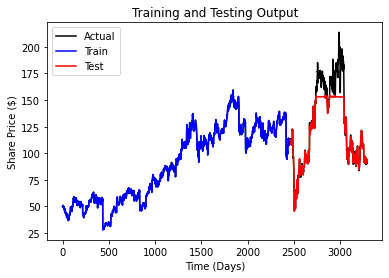

In [77]:
# KNN regression
knn = KNeighborsRegressor(n_neighbors=33, n_jobs=-1, leaf_size=10, p=2, weights='distance').fit(xTrain, yTrainRegress) # need to look into the amount of neighbors and jobs
knnModel = knn.fit(xTrain, yTrainRegress)
trainKnnPredict = knnModel.predict(xTrain)
yKnnPredict = knnModel.predict(xTest)

testPredictKnnPlot = np.empty_like(data['Close'])
testPredictKnnPlot[:] = np.nan
testPredictKnnPlot[len(trainKnnPredict):len(data)] = yKnnPredict

# Plot the test predictions
plt.plot(data['Close'], color="black", label=f"Actual")
plt.plot(trainKnnPredict, color="blue", label=f"Train")
plt.plot(testPredictKnnPlot, color="red", label=f"Test")
plt.title("Training and Testing Output")
plt.xlabel("Time (Days)")
plt.ylabel("Share Price ($)")
plt.legend()
plt.show()

In [78]:
# KNN classifier - best k-value I've found: 33
knnModel = KNeighborsClassifier(n_neighbors=33, n_jobs=-1, leaf_size=10, p=2, weights='distance').fit(xTrain, yTrainClass) # need to look into the amount of neighbors and jobs
yKnnPredict = knnModel.predict(xTest)
accuracy_score(yTestClass, yKnnPredict)

plt.figure(figsize=(30,12), dpi=600)
data2 = data['Close'].iloc[-len(yTestClass):]
plt.plot(data2.reset_index(drop=True), color='black')
for idx, i in enumerate(data['Close'].iloc[-len(yTestClass):]):
    plt.scatter(idx, i, marker=getSymbols(yKnnPredict[idx]), color=getColors(yTestClass[idx], yKnnPredict[idx]), zorder=2, alpha=0.5)

0.511543134872418

In [79]:
# LinearSVC for a large dataset
svc = LinearSVC() # support vector classifier
svcModel = svc.fit(xTrain, yTrainClass)
svcPredict = svcModel.predict(xTest)
print(accuracy_score(yTestClass, svcPredict))

plt.figure(figsize=(30,12), dpi=600)
data2 = data['Close'].iloc[-len(yTestClass):]
plt.plot(data2.reset_index(drop=True), color='black')
for idx, i in enumerate(data['Close'].iloc[-len(yTestClass):]):
    plt.scatter(idx, i, marker=getSymbols(svcPredict[idx]), color=getColors(yTestClass[idx], svcPredict[idx]), zorder=2, alpha=0.5)

0.4993924665856622
['Down' 'Up' 'Down' 'Up' 'Up' 'Up' 'Up' 'Up' 'Up' 'Up' 'Up' 'Up' 'Up' 'Up'
 'Up' 'Up' 'Up' 'Up' 'Up' 'Up' 'Up' 'Up' 'Up' 'Down' 'Down' 'Down' 'Up'
 'Down' 'Up' 'Up' 'Down' 'Down' 'Down' 'Down' 'Down' 'Down' 'Down' 'Down'
 'Down' 'Down' 'Down' 'Down' 'Down' 'Down' 'Down' 'Up' 'Up' 'Down' 'Up'
 'Down' 'Up' 'Up' 'Down' 'Down' 'Down' 'Up' 'Up' 'Down' 'Up' 'Up' 'Up'
 'Up' 'Up' 'Down' 'Down' 'Up' 'Up' 'Up' 'Up' 'Up' 'Down' 'Up' 'Up' 'Up'
 'Down' 'Up' 'Up' 'Up' 'Down' 'Down' 'Down' 'Up' 'Up' 'Down' 'Up' 'Down'
 'Up' 'Up' 'Up' 'Down' 'Up' 'Down' 'Up' 'Up' 'Down' 'Up' 'Up' 'Down'
 'Down' 'Down' 'Down' 'Up' 'Down' 'Up' 'Up' 'Up' 'Down' 'Up' 'Up' 'Down'
 'Up' 'Down' 'Up' 'Down' 'Up' 'Up' 'Up' 'Down' 'Up' 'Up' 'Down' 'Up' 'Up'
 'Up' 'Up' 'Up' 'Up' 'Up' 'Up' 'Up' 'Up' 'Up' 'Up' 'Up' 'Up' 'Up' 'Down'
 'Up' 'Down' 'Down' 'Up' 'Up' 'Up' 'Up' 'Up' 'Up' 'Up' 'Down' 'Down' 'Up'
 'Up' 'Up' 'Down' 'Up' 'Up' 'Down' 'Down' 'Up' 'Up' 'Up' 'Up' 'Up' 'Up'
 'Up' 'Down' 'Up' 'Up' 'Up' 'Down' 'U

In [80]:
# Perceptron
percep = Perceptron()
percepModel = percep.fit(xTrain, yTrainClass)
percepPredict = percepModel.predict(xTest)
print(accuracy_score(yTestClass, percepPredict))
print(percepPredict)

0.5078979343863913
['Up' 'Up' 'Up' 'Up' 'Up' 'Up' 'Up' 'Up' 'Up' 'Up' 'Up' 'Up' 'Up' 'Up'
 'Up' 'Up' 'Up' 'Up' 'Up' 'Up' 'Up' 'Up' 'Up' 'Up' 'Up' 'Up' 'Up' 'Up'
 'Up' 'Up' 'Up' 'Up' 'Up' 'Up' 'Up' 'Up' 'Up' 'Up' 'Up' 'Up' 'Up' 'Up'
 'Up' 'Up' 'Up' 'Up' 'Up' 'Up' 'Up' 'Up' 'Up' 'Up' 'Up' 'Up' 'Up' 'Up'
 'Up' 'Up' 'Up' 'Up' 'Up' 'Up' 'Up' 'Up' 'Up' 'Up' 'Up' 'Up' 'Up' 'Up'
 'Up' 'Up' 'Up' 'Up' 'Up' 'Up' 'Up' 'Up' 'Up' 'Up' 'Up' 'Up' 'Up' 'Up'
 'Up' 'Up' 'Up' 'Up' 'Up' 'Up' 'Up' 'Up' 'Up' 'Up' 'Up' 'Up' 'Up' 'Up'
 'Up' 'Up' 'Up' 'Up' 'Up' 'Up' 'Up' 'Up' 'Up' 'Up' 'Up' 'Up' 'Up' 'Up'
 'Up' 'Up' 'Up' 'Up' 'Up' 'Up' 'Up' 'Up' 'Up' 'Up' 'Up' 'Up' 'Up' 'Up'
 'Up' 'Up' 'Up' 'Up' 'Up' 'Up' 'Up' 'Up' 'Up' 'Up' 'Up' 'Up' 'Up' 'Up'
 'Up' 'Up' 'Up' 'Up' 'Up' 'Up' 'Up' 'Up' 'Up' 'Up' 'Up' 'Up' 'Up' 'Up'
 'Up' 'Up' 'Up' 'Up' 'Up' 'Up' 'Up' 'Up' 'Up' 'Up' 'Up' 'Up' 'Up' 'Up'
 'Up' 'Up' 'Up' 'Up' 'Up' 'Up' 'Up' 'Up' 'Up' 'Up' 'Up' 'Up' 'Up' 'Up'
 'Up' 'Up' 'Up' 'Up' 'Up' 'Up' 'Up' 'Up' 'Up' 'Up' 'Up' 'U